In [1]:
import os
os.chdir("../")

In [2]:
from src.entity import AgentState, get_database_schema, engine, CheckRelevance, ConvertToSQL
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.config import RunnableConfig
from langchain_cohere import ChatCohere
from langgraph.graph import StateGraph, END
from src.get_current_user import get_current_user
from src.check_revelance import check_relevance
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "END"

In [4]:
def convert_nl_to_sql(state: AgentState, config: RunnableConfig):
    question = state["question"]
    current_user = state["current_user"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL for user '{current_user}': {question}")
    system = """You are an assistant that converts natural language questions into SQL queries based on the following schema:

        {schema}

        The current user is '{current_user}'. Ensure that all query-related data is scoped to this user.

        use sql_query to provide only the SQL query without any explanations. Alias columns appropriately to match the expected keys in the result.
        there can me multiple query for a particular question.
        For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
    """.format(schema=schema, current_user=current_user)
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = ChatCohere(model = "command-r-plus-08-2024",temperature=0)
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f"Generated SQL query: {state['sql_query']}")
    # print(state)
    return state

In [5]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_edge("get_current_user", "check_relevance")
workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "END": END,
    },
)
workflow.add_edge("convert_to_sql", END)
workflow.set_entry_point("get_current_user")

app = workflow.compile()

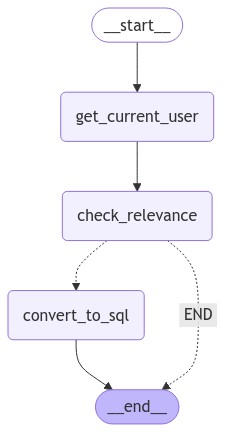

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    pass

In [8]:
config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "Show me my orders"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1)

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: Show me my orders
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'User 2': Show me my orders
Generated SQL query: SELECT food.name AS food_name, food.price AS price FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;
Result: {'question': 'Show me my orders', 'sql_query': 'SELECT food.name AS food_name, food.price AS price FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;', 'current_user': 'User 2', 'attempts': 0, 'relevance': 'relevant'}


In [9]:
print(result_1['sql_query'])

SELECT food.name AS food_name, food.price AS price FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;
